# Tutorial  \# 5 Monte Carlo and Bootstrap #

In this tutorial we will use the techniques of Monte Carlo simulation and Bootstrap resampling to estimate the errors in a statistic.

In some situations a statistic might have a known distribution, but in other cases it is not possible to analytically derive the distribution of the statistic.  If we know the statistical distribution of the data and we can simulate data from it numerically, then we can find the distribution of our statistic by repeatedly calculating it on simulated data sets.  This is called a Monte Carlo (MC) simulation or a parametric bootstrap.

The idea is to estimate the expectation value of any statistic $f(\{x\})$ with
\begin{align}
E[f] \simeq E_{\rm mc}[f] \equiv \frac{1}{N_{\rm mc}} \sum_i^{N_{\rm mc} } f\left( \{ x  \}_i  \right)
\end{align}

where the $\{ x \}_i$ is the $i$th simulated data set.  This can be used to find the bias and variance of any statistic as long as you can generate random samples from the distribution.  The estimated bias for a parameter $\theta$ is 
\begin{align}
{\rm bias}_\theta = E_{\rm mc}[\hat{\theta}] - \theta
\end{align}
where $\theta$ is the parameter value used in generating the MC samples and $\hat{\theta}$ is an estimator of that parameter.

An estimate for the variance of this estimator will be
\begin{align}
{\rm Var}_{\rm mc}[\hat{\theta}] &= \frac{1}{(N_{\rm mc}-1) }  \sum_i^{N_{\rm mc} } 
\left( ~ \hat{\theta}\left( \{ x  \}_i  \right)  -  E_{\rm mc}[\hat{\theta}] ~ \right)^2
\end{align}


**Gaussian case:**
First we will investigate the mean and median of a sample drawn from a Gaussian distribution.  In this case we have a library function that will generate deviates from a normal distribution.  We saw in lecture that the sample mean of a sample drawn from a normal distribution is normally distributed with a variance of $\sigma^2/n$. We will verify this using a MC simulation.

In [267]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import mpmath as mp

In [268]:
# 1) Consider a data set of n=10  drawn from a N(0,1) distribution.  
# Create a random data set and find the mean and median of that data set.

Nsample = 10
ran_set=np.random.random(size=Nsample)
print('mean = ', np.mean(ran_set))
print('median = ', np.median(ran_set))


mean =  0.39793338288485336
median =  0.3813251926333157


In [269]:
#2) Find the bias and variance of the sample mean and median by simulating 
#  N_mc=1000 data sets each of size n=10.  Put the above into a loop to find the 
#  bias and variance of the mean and median of sets of 10.

Nmc = 1000
means = np.empty(Nmc)
medians = np.empty(Nmc)



for i in range(1000):
    Nsample = 10
    ran_set=np.random.random(size=Nsample)
    means[i]=np.mean(ran_set)
    medians[i]=np.median(ran_set)
    
print('Var of means ', np.var(means))
print('Var of medians ', np.var(medians))

ave_1=np.average(means)
ave_2=np.average(medians)

print('Bias of means', np.average(means-ave_1))
print('Bias of medians', np.average(medians-ave_2))


# What is the prediction of theory for the variance of the mean?
# Does the result of this MC experiment agree with theory?



#Is the variance of the median larger or smaller than the mean?


Var of means  0.008297169533586831
Var of medians  0.018985834704024696
Bias of means 1.6431300764452316e-17
Bias of medians -2.176037128265307e-17


We are now going to look at a somewhat more realistic example where the bias and variance of the statistic, in this case an estimator, is not known analytically.  The Schechter luminosity function is used to model the distribution of galaxy luminosities and many other things such as dark matter halo mass functions.  It is given by
\begin{align}
n(L) = \phi_* \left( \frac{L}{L_*}\right)^\alpha ~ e^{-L/L_*}~ \frac{dL}{L_*}
\end{align}
This has three parameters, $ \phi_*$, $\alpha$ and $L_*$.  For galaxies $\alpha \simeq -1.25$, but we will be using the case of $\alpha = -0.3$ (This avoids the complication of it requiring a lower limit to be normalizable.).
We want to measure the value of $L_*$.  The normalization $\phi_*$ will not be relevant because we are interested in the distribution and not the over all density.  An estimator for $L_*$ is 
\begin{align}
\hat{L}_* = \left( \frac{1}{(1+\alpha) n}  \sum_{i=1}^n L_i  \right)
\end{align}
where $L_i$ are the luminosities of each observed galaxy and $n$ is the number of galaxies in the data set.  We want to know if this estimator is biased and what its variance is.


In this case we do not have a library function to get random deviates from this distribution so we will have to build one ourselves.

3) Make a function that takes the luminosity $ x = L/L_*$ and returns the properly normalized pdf for galaxy luminosities.  Take the minimum luminosity to be $x_{min} = 0.0$.
You will find the following integrals useful
\begin{align}
\Gamma(\alpha+1 ) =\int^{\infty}_{0} dx ~x^\alpha ~ e^{-x}
\end{align}
where $\Gamma(\alpha+1) $ is the gamma function.  The 
incomplete gamma function is
\begin{align}
\Gamma(\alpha+1,c, b) =\int^{b}_{c} dx ~x^\alpha ~ e^{-x}
\end{align}
These can be calculated using the mpmath library.


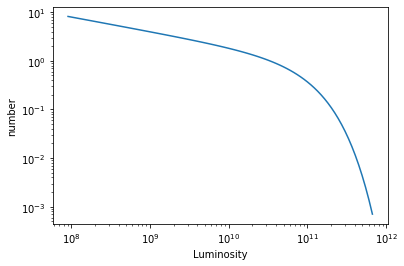

In [270]:
Lstar = 1.0e11
alpha = -0.3

def schechter(x=np.array([])) :
    sch_lu =  (x**alpha)*np.e**(-x)
    #gamma=integrate.quad(pdf_lu, 0, np.inf)
    return sch_lu

## vectorize the function so that it will take a vector
schechterV = np.vectorize(schechter)

# Make a plot of the pdf.  To make it look good you will probably need to 
# use plt.x(y)scale('log') to plot it in log scale. Label the axis.

lnx = np.arange(-7,2,0.1) # evenly spaced in log
x = np.exp(lnx)

p = schechterV(x)
L = x*Lstar

plt.xscale('log')
plt.yscale('log')

plt.plot(L, p)
plt.xlabel('Luminosity')
plt.ylabel('number')

plt.show()

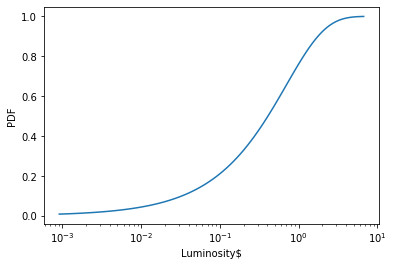

In [271]:
#4) Make a function that returns the cumulative distribution for x = L/Lstar.  
# Call it F.  This should not require summing the above.  You should write it 
# using the incomplete gamma functions.

def F(xx=np.array([])) :
    pdf_lu=np.zeros(len(xx))
    for j in range(len(xx)):
        if(xx[j] <= 0) :        
            pdf_lu[j] = 0.0
        else :
            sch_lu =  lambda m : (m**alpha)*np.e**(-m)
            pdf_lu[j] = mp.gammainc(alpha+1.0, 0, xx[j], regularized=True)
        
    return (pdf_lu)

#FV = np.vectorize(F)

pdf=F(x)

## Plot the cumulative distribution.
## It should go from 0 to 1 if you have used enough of a range in 
## x. Put some labels on it.
plt.xscale('log')


plt.plot(x, pdf)
plt.xlabel('Luminosity$')
plt.ylabel('PDF')

plt.show()

In [272]:
print(lnx[np.where(pdf==max(pdf))])
print(lnx[np.where(pdf==min(pdf))])

[1.9]
[-7.]


Now we want to create a function for generating random deviates from the Schechter distribution. We can do this by inverting the cumulative distribution
 to get the quantile function.  If then put uniform random deviates between 0 and 1 into this function we will get out random deviates drawn from the Schechter distribution.  We will need to invert the cumulative distribution numerically in this case because it cannot be done analytically.

 5) First we need two arrays for pairs of $log(x)$ and $F(x)$.  
 We saw in the plot above that $F(x)$ is smooth if we use 
 $log(x)$ so it is better to interpolate in $log(x)$
 instead of $x$. Because $log(x)$ is not defined at 
 $x=0$ we also need to be sure that the 
 interpolation table covers the range from 
 $F(x) = 0$ to $F(x) = 1$ well enough that all likely 
 values are represented. 

In [273]:
# Arrays for interpolation within the quantile function

lnx_int = np.arange(-7,2,0.01) # evenly spaced in log
x_int = np.exp(lnx_int)
f_int = F(x_int)
# These arrays need to have different names from above 
# so that they don't change when the variables are reassigned.

## Below is the code for inverting the cumulative 
## distribution "by hand".  You should understand 
## it and then make it more efficient by 
## uncommenting the numpy functions that do the 
## same thing internally.
## 
 
def quantile(u) :
    # if out of bounds
    if(u <= f_int[0]) :
        return lnx_int[0]
    if(u >= f_int[-1]) :
        return lnx_int[-1]
    # find where u is in f array
    # i=0
    #while(f_int[i] < u):
    #i += 1
    #i -= 1
    #return lnx_int[i] + (u-f_int[i])*(lnx_int[i+1]-lnx_int[i])/(f_int[i+1]-f_int[i])
    return np.interp(u,f_int.astype('float'),lnx_int.astype('float'))

## This makes a vector version of the function
def quantileV(u) :
    ans = np.empty(len(u))
    for i in range(len(u)) :
        ans[i] = quantile(u[i])
    return ans
#quantileV = np.vectorize(quantile)

## Now we can draw randomly from the Schechter 
## distribution by passing uniform random numbers
## into the quantile function.
## Here are 1000 luminosities taken from the 
## distribution.

u = np.random.uniform(0,1,1000)
lnx = quantileV(u)


 6) Verify that the random numbers created above 
 do in fact come from the Schechter 
 distribution by making the empirical cumulative 
 distribution of them and over-plotting
 the cumulative distribution we found before in 4).

Text(0, 0.5, 'cdf')

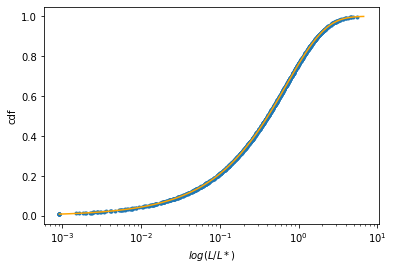

In [274]:
plt.scatter(np.exp(lnx), F(np.exp(lnx)), marker='.', label='cdf from random number')
plt.plot(x, pdf, c='orange', label='cumulative distribution')

plt.xscale('log')
plt.xlabel('$log(L/L*)$')
plt.ylabel('cdf')

 7) Now that we have a way of generating random luminosities we can
   find the bias and variance of the estimator for $L_*$ given above.
   Do 10000 random data sets of 20 galaxies each and find the bias and 
   variance.

In [275]:
Nmc = 10000
Nsample = 20

Lstar_estimates = np.zeros(Nmc)

for i in range(Nmc):
    nn = np.random.uniform(0,1,20)
    ln_nn=quantileV(nn)
    Lstar_estimates[i] = np.sum(Lstar*np.exp(ln_nn))*(1/((1+alpha)*Nsample))
    
print('means Lstar', np.mean(Lstar_estimates)/Lstar)
print('bias', np.mean(Lstar_estimates)/Lstar-1)
print('standard deviation Lstar ', np.std(Lstar_estimates)/Lstar)


means Lstar 0.999686335959365
bias -0.00031366404063504216
standard deviation Lstar  0.2685757797103084


 8) If you increase the sample size does the bias 
 and/or variance of the estimator change?  
 Make a plot of the bias and standard deviation 
 as a function of the sample size from 3 to 200 
 skipping every 10 (i.e. Nsample = 3,13,23,..)

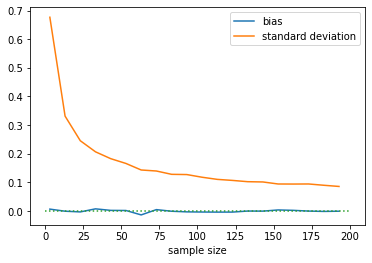

-0.0006061591507289021


In [276]:

Nmc = 1000

bi_ass=np.zeros(len(np.arange(3,200,10)))
stdd=np.zeros(len(np.arange(3,200,10)))

x=0
for i in np.arange(3,200,10):
    Nsample=i
    Lstar_estimates = np.zeros(Nmc)
    for j in range(Nmc):
        mm = np.random.uniform(0,1,Nsample)
        ln_mm=quantileV(mm)
        Lstar_estimates[j]= np.sum(Lstar*np.exp(ln_mm))*(1/((1+alpha)*Nsample))
    bi_ass[x]=np.mean(Lstar_estimates)/Lstar-1
    stdd[x]=np.std(Lstar_estimates)/Lstar
    x+=1    
        
plt.plot(np.arange(3, 200, 10), bi_ass, label='bias')
plt.plot(np.arange(3,200, 10), stdd, label='standard deviation')
plt.plot([0,200],[0,0],linestyle=':')
plt.legend()
plt.xlabel('sample size')
plt.show()

print(np.average(bi_ass))

This estimator of $L_*$ is not very good when $\alpha=-1.25$ (you can try it and see) and so should not be used to fit $L_*$ from real galaxy luminosity data.  The reason for this is that the luminosity function diverges at $L=0$ in this case.  As a result the selection function is always important and the estimator must be modified for this.  

For **extra credit** consider an alternative estimator for $L_*$.  $F(x=1) = 0.76$ (where $x=L/L_*$) so taking the 0.76 quantile of the data might be a good estimator for $L_*$.  This is the data point for which 76\% of the data has a smaller value and 24\% of the data has a larger value.  (The 0.5 quantile is the median.)  You can find functions for doing this in numpy or sort the data yourself.  When there are too few data points (Nsample <~ 5) you can take the maximum data point. 

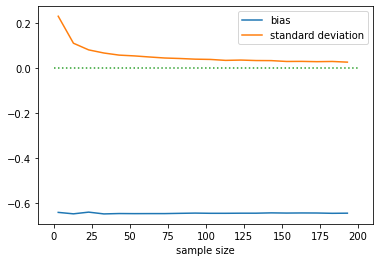

 Is this estimator biased?
not really
Does it have a lower or higher variance than the estimator we already considered for the same sample size?
-0.6440360276951491
The number is lower, the data is more biased


In [277]:
# 9)
# Write a function that takes the data and returns the new estimate 
# for L_* by returning the 0.76 quantile.

def quantile_76(u=np.array([])):
    result=u[np.where(u<=1.e11)]    
    return (result)


Nmc = 1000

bi_ass=np.zeros(len(np.arange(3,200,10)))
stdd=np.zeros(len(np.arange(3,200,10)))

x=0
for i in np.arange(3,200,10):
    Nsample=i
    Lstar_estimates = np.zeros(Nmc)
    for j in range(Nmc):
        mm = np.random.uniform(0,1,Nsample)
        ln_mm=np.exp(quantileV(mm))
        ln_mm*=Lstar
        cut_76=quantile_76(ln_mm)
        Lstar_estimates[j]= np.sum(cut_76)*(1/((1+alpha)*Nsample))
        
    if i <= 5:
        bi_ass[x]=max(Lstar_estimates)/Lstar
        stdd[x]=0
    
    bi_ass[x]=np.mean(Lstar_estimates)/Lstar-1
    stdd[x]=np.std(Lstar_estimates)/Lstar
    x+=1    
        
plt.plot(np.arange(3, 200, 10), bi_ass, label='bias')
plt.plot(np.arange(3,200, 10), stdd, label='standard deviation')
plt.plot([0,200],[0,0],linestyle=':')
plt.legend()
plt.xlabel('sample size')
plt.show()








# Plot the bias and variance as a function of sample size as before. 
# These are found by applying estimator to many samples drawn from 
# the distribution.

print (' Is this estimator biased?')
print ('not really')

print ('Does it have a lower or higher variance than the estimator we already considered for the same sample size?')
print (np.average(bi_ass))
print ('The number is lower, the data is more biased')

## Bootstrap errors ##

Now let's apply the estimator to a data set, but this time we will use bootstrap resampling to estimate the variance of the estimator.  There is noise in the luminosity measurements and we do not know how it is distributed.

Read in the luminosity data from the file `luminosities.csv`.  
Make a loop that resamples this data 2500 times with bootstrap resampling each time. (hint: use np.random.randint() to make a new index each time.)

Make a histogram of the estimated $L_*$s for the bootstrap samples. 

Calculate the standard deviation of the estimated $L_*$ for these samples and report the result.

In [281]:
import pandas as pa
df = pa.read_csv('./luminosities.csv')
L=df.luminosity
alpha=-0.3

in unit of 1.e11
mean of the sample: 133.97421052293845 
 mean of the bootstrap: 133.96644986568302
L_* =  133.96644986568302  +/-  0.9113615301240242


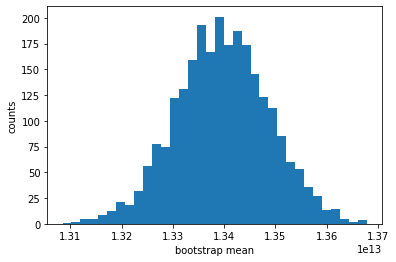

In [284]:
Lave = np.mean(L)/(alpha + 1)
n = 2500
lstars = np.zeros(n)
for i in range(n) :
    index=np.random.randint(0,len(L), len(L)*10)
    lstars[i] = np.mean(L[index])/(alpha + 1)
    
# histogram of lstars
plt.hist(lstars,bins='auto')
plt.xlabel('bootstrap mean')
plt.ylabel('counts')

print('in unit of 1.e11')

print('mean of the sample:', Lave/1.e11, '\n mean of the bootstrap:', np.mean(lstars)/1.e11)
std_boot=np.std(lstars)
print('L_* = ', np.mean(lstars)/1.e11,' +/- ',std_boot/1.e11)